# Keras Basics
We will learn about
* Dense layers
* Categorical cross-entropy

A toy example to show how to train a classifier with Keras and use it. The data comes from three gaussian distributions.

In [0]:
## DATA GENERATION
import numpy as np

def generateX(cls):
    '''
    Inputs:
        cls: class {0, 1, 2}
    Outputs:
        x: a sample from cls; a np array of shape (2,)
    '''
    assert cls in [0,1,2]
    
    if cls==0:
        x = np.random.normal(np.array([0,0]),100)
    elif cls==1:
        x = np.random.normal(np.array([200,200]),100)
    elif cls==2:
        x = np.random.normal(np.array([-200,200]),100)
    return x
Nx = 2 # shape of a sample is (2,)
Ny = 3 # 3 classes

Could you write a function to generate N samples from class 0 and N samples from class 1?

In [0]:
def generateXY(N):
    '''
    Inputs:
        N: no. of samples of each class
    Outputs:
        X: np array of samples; shape = (3*N, 2)
        Y: np array of samples; shape = (3*N, 1)
    '''
    # YOUR CODE HERE
    X = np.ones((3*N,2))
    
    for j in range(3*N):
      if(j<N):
        for k in range(N):
          X[k,:] = generateX(0)
        continue
      if(j<2*N):
        for k in range(N):
          X[k,:] = generateX(1)
        continue
      if(j<3*N):
        for k in range(N):
          X[k,:] = generateX(2)
        continue
    
    Y = np.ones((3*N,1))
    
    for i in range(3*N):
      if(i<N):
        Y[i,0]=0
        continue
      if(i<2*N):
        Y[i,0]=1
        continue
      else:
        Y[i,0] = 2
        continue
      
    
    return X, Y

In [8]:
def test_generateXY():
    X_train, Y_train = generateXY(50)
    assert X_train.shape==(150,2)
    assert Y_train.shape==(150,1)
    print('Test passed', '\U0001F44D')
test_generateXY()

Test passed 👍


### One-hot encoding

Now our Y is in the form [0], [1] and [2]. We want to convert them to [1,0,0], [0,1,0] and [0,0,1], respectively. 
Could you write a code to convert Y (with one column) into one-hot encoded Y (with 3 columns)?

In [0]:
def oneHot(y, Ny):
    '''
    Input:
        y: an int in {0, 1, 2}
        Ny: Number of classes, e.g., 3 here.
    Output:
        Y: a vector of Ny (=3) tuples
    '''
    # YOUR CODE HERE
    Y = np.zeros((1,Ny))
    for i in range(Ny):
      if(i==y):
        Y[0,i]=1
    return Y


In [10]:
def test_oneHot():
    assert np.all(oneHot(0,3)==np.array([1,0,0]))
    assert np.all(oneHot(1,3)==np.array([0,1,0]))
    assert np.all(oneHot(2,3)==np.array([0,0,1]))
    print('Test passed', '\U0001F44D')
test_oneHot()

Test passed 👍


### Input Normalization
X can lie in any unbounded range. We need to curtail to a narrow range close to zero. This helps in enhancing the stability of training and hyper-parameter tuning.
This is normally achieved by scaling the X to have zero mean and unit standard deviation (std).

$X \leftarrow \frac{X-mean(X)}{std(X)}$, where this is element wise division

Could you use training samples to find mean and std, and normalize your X_train with that?

In [0]:
def findMeanStddev(X):
    '''
    Input: 
        X: a matrix of size (no. of samples, dimension of each sample)
    Output:
        mean: mean of samples in X; shape is (dimension of each sample,)
        stddev: element-wise std dev of sample in X; shape is (dimension of each sample,)
    '''
    # YOUR CODE HERE
    mean = X.mean(axis=0)
    stddev=X.std(axis=0)
    return mean, stddev

In [12]:
def test_findMeanStddev():
    X = np.array([[3,2,6],[7,4,2],[3,5,1]])
    mean, stddev = findMeanStddev(X)
    assert np.isclose(mean, np.array([4.33, 3.66, 3.]), atol=0.1).all()
    assert np.isclose(stddev, np.array([1.88, 1.24, 2.16]), atol=0.1).all()
    print('Test passed', '\U0001F44D')
test_findMeanStddev()

Test passed 👍


In [0]:
def normalizeX(X, mean, stddev):
    '''
    Input:
        X: a matrix of size (no. of samples, dimension of each sample)
        mean: mean of samples in X (same size as X)
        stddev: element-wise std dev of sample in X (same size as X) 
    Output:
        Xn: X modified to have 0 mean and 1 std dev
    '''
    # YOUR CODE HERE
    Xn=X
    if(stddev[0,] == 0):
      Xn=Xn*0
    else:
       Xn=(X-mean)/stddev
    return Xn

In [14]:
def test_normalizeX():
    X = np.ones((3,3))
    m,s = findMeanStddev(X)
    assert np.all(m==np.ones(3))
    assert np.all(s==np.zeros(3))
    assert np.all(normalizeX(X,m,s)==0*X)
    # test on random X
    X = np.random.random((5,3))
    m,s = findMeanStddev(X)
    Xn = normalizeX(X,m,s)
    mn, sn = findMeanStddev(Xn)
    assert np.allclose(mn, np.zeros(3))
    assert np.allclose(sn, np.ones(3))
    print('Test passed', '\U0001F44D')
test_normalizeX()

Test passed 👍


### Plotting
Could you plot all the samples in X_train with different colors for different classes?

In [0]:
import matplotlib.pyplot as plt
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
def plotXY(X, Y):
    '''
    Inputs:
        X: a matrix of size (no. of samples, dimension of each sample)
        Y: a matrix of size (no. of samples, no. of classes) - these are one-hot vectors
    Action:
        Plots the samples in X, their color depends on Y
    '''
    Ny = Y.shape[1]
    for cls in range(Ny):
        idx = np.where(Y[:,cls]==1)[0]
        plt.plot(X[idx,0], X[idx,1], colors[cls]+'.')


## Creating the Network
We now create the network with dense layers: 
$y = f(Wx)$

ReLU activation: 
$f(h) = h, h>0; 0, h\le 0$

Softmax activation: 
$f(h_i) = \frac{\exp(h_i)}{\sum_j \exp(h_j)}$

Categorical cross-entropy loss:
$\mathcal{L} = -\sum_t y^d_t \log y_t$

Stochastic Gradient Descent:
$w_{ij} \leftarrow w_{ij} - \eta \frac{\partial \mathcal{L}}{\partial w_{ij}}$

In [0]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

def makeNN(Nx, Nh, Ny):
    '''
    Input:
        Nx: int; no. of input nodes; shape of each sample; i.e., X.shape[1:] 
        Nh: int; no. of hidden neurons
        Ny: int; no. of output nodes; shape of output; i.e., Y.shape[1]
    Output:
        model: keras NN model with Input layer, Dense layer with Nh neurons, 
                and Dense output layer with softmax non-linearity, loss function
                categorical-crossentropy, optimizer SGD.
    '''
    # YOUR CODE HERE
    input_layer = Input(shape =( Nx,))
    hidden_layer1 = Dense(Nh, activation = 'relu',)(input_layer)
    hidden_layer2 = Dense(Nh, activation = 'tanh',)(hidden_layer1)
    output_layer = Dense(Ny, activation = 'softmax')(hidden_layer2)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    

    return model

### Plotting the model

In [0]:
def plotModel(model):
    from keras.utils import plot_model
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
    from IPython.display import Image
    Image(retina=True, filename='model.png')

### Training


In [0]:
def trainNN(model, X_train, Y_train, Nepochs):
    '''
    Action:
        Train model with model.fit
    '''
    # YOUR CODE HERE
    history = model.fit(X_train,Y_train,batch_size=10,epochs=Nepochs,validation_split = 0.4)
    import matplotlib.pyplot as plt

    plt.plot(history.history['val_acc'])

In [0]:
def trainModel(N, Nh, Nepochs):
    '''
    generateXY, normalizeX, oneHot, makeNN, trainNN
    Input:
        N: int; no. of training samples per class
        Nh: int; no. of neurons in hidden layer
    Output:
        model: keras NN model trained with the training data
        mean_train, stddev_train: mean and stddev of training data - you will 
                            need this for normalizing your test data
    '''
    # YOUR CODE HERE
    X,Y=generateXY(N)
    plotXY(X, Y)
    print(Y.shape)
    m,s=findMeanStddev(X)
    X=normalizeX(X,m,s)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    from keras.utils import to_categorical
    Yc = to_categorical(Y)
    print(Yc.shape)
    train_frac = 0.8
    train_samples = indices[:int(train_frac*X.shape[0])]
    ## this is really awesome hes picking first 80% train indices then next others
    test_samples = indices[int(train_frac*X.shape[0]):]
    x_train = X[train_samples]
    y_train = Yc[train_samples]

    
    x_test = X[test_samples]
    y_test = Yc[test_samples]
    yn_test = Y[test_samples]
    
    Nx=2
    Ny=3
    model=makeNN(Nx, Nh, Ny)
    mean_train,stddev_train= findMeanStddev(X)
    trainNN(model,x_train,y_train, Nepochs)
     
    
    return model, mean_train, stddev_train,x_test,y_test,yn_test

### Evaluation
Could you:
- Generate 20 samples from each class
- Normalize them with mean_train and stddev_train
- Get Y_test as one hot encoded labels

(300, 1)
(300, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 42)                126       
_________________________________________________________________
dense_20 (Dense)             (None, 42)                1806      
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 129       
Total params: 2,061
Trainable params: 2,061
Non-trainable params: 0
_________________________________________________________________
Train on 144 samples, validate on 96 samples
Epoch 1/500
144/144 [==============================] - 1s 4ms/step - loss: 1.3028 - acc: 0.0069 - val_loss: 1.2586 - val_acc: 0.0104
Epoch 2/500
144/144 [==============================] - 0s 189us/step - loss:

array([[22,  0,  2],
       [ 0,  0, 19],
       [ 0,  0, 17]])

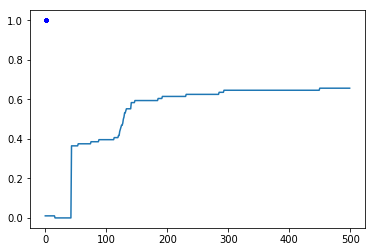

In [55]:
model, mean_train, stddev_train,x_test,y_test,yn_test = trainModel(100, 42, 500)
accuracy, CM = testModel(model, 10, mean_train, stddev_train,x_test,y_test)
#testModel(model, Ntest, mean_train, stddev_train,x_test,y_test)
CM

In [0]:
plotModel(model)

In [0]:
def testModel(model, Ntest, mean_train, stddev_train,x_test,y_test):
    '''
    generateXY for test, normalize, onehot, evaluate the model
    Inputs:
        model: trained Keras NN model
        Ntest: int; number of test samples per class
    Output:
        accuracy: float; accuracy on the test data
        CM: confusion matrix on the test data
    '''
    # YOUR CODE HERE
    
    from sklearn.metrics import confusion_matrix
    loss, accuracy = model.evaluate(x_test,y_test,verbose=0)
    pred_labels = model.predict(x_test)
    
    CM = confusion_matrix(yn_test, pred_labels.argmax(axis=1))

    return accuracy, CM


# ADVANCED QUESTIONS



### Effect of changing Nh
### Effect of changing Nepochs
### Effect of changing N, no. of training samples

Can you observe overfitting? 

Can you do hyperparameter tuning here? 

To normalize test data, why do we use the mean and stddev of training data?
